# Cumulative emissions

This example will walk through calculating and visulaizing cumulative emissions. 

In [1]:
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from openclimate import Client
import numpy as np
import pandas as pd

We will first initialize a `Client()` object.

In [2]:
client = Client()

If you are using a jupyter enviornment, you will need to first `client.jupyter`. 
This patches the `asyncio` library to work in Jupyter envionrments using [nest-asyncio](https://pypi.org/project/nest-asyncio/).

In [3]:
client.jupyter

## Get country codes 

OpenClimate references each country by its two-letter [ISO-3166](https://www.iso.org/iso-3166-country-codes.html) code.
To access this in `openclimate` we can use the `.parts()` method to get all the "parts" of EARTH. Other codes we use are [UN/LOCODEs](https://unece.org/trade/cefact/unlocode-code-list-country-and-territory) for cities and [LEI](https://www.gleif.org/en/about-lei/introducing-the-legal-entity-identifier-lei) for companies. As a catch-all term, we call them an `actor_id`.

In [4]:
df_country = client.parts('EARTH')

Looking at the dataframe that's returned, we have a column with each country's `actor_id`. 

In [5]:
df_country.head()

,actor_id,name,type,has_data,has_children,children_have_data
5,AD,Andorra,country,True,None,None
234,AE,United Arab Emirates,country,True,None,None
0,AF,Afghanistan,country,True,None,None
9,AG,Antigua and Barbuda,country,True,None,None
7,AI,Anguilla,country,True,None,None


Let's save just the `actor_id` to a list 

In [6]:
iso_and_name = list(zip(df_country['actor_id'], df_country['name']))

## Which datasets are available?

To get a list of datasets available for an actor you can use the `.emissions_datasets()` method.
Here I am asking for datasets with Candian emissions.

In [7]:
client.emissions_datasets('CA')

,actor_id,datasource_id,name,publisher,published,URL
0,CA,BP:statistical_review_june2022,"Statistical Review of World Energy all data, 1...",BP,2022-06-01T00:00:00.000Z,https://www.bp.com/en/global/corporate/energy-...
1,CA,EDGARv7.0:ghg,Emissions Database for Global Atmospheric Rese...,JRC,2022-01-01T00:00:00.000Z,https://edgar.jrc.ec.europa.eu/dataset_ghg70
2,CA,GCB2022:national_fossil_emissions:v1.0,Data supplement to the Global Carbon Budget 20...,GCP,2022-11-04T00:00:00.000Z,https://www.icos-cp.eu/science-and-impact/glob...
3,CA,PRIMAP:10.5281/zenodo.7179775:v2.4,PRIMAP-hist_v2.4_no_extrap (scenario=HISTCR),PRIMAP,2022-10-17T00:00:00.000Z,https://zenodo.org/record/7179775
4,CA,UNFCCC:GHG_ANNEX1:2019-11-08,"UNFCCC GHG total without LULUCF, ANNEX I count...",UNFCCC,2019-11-08T00:00:00.000Z,https://di.unfccc.int/time_series
5,CA,climateTRACE:country_inventory,climate TRACE: country inventory,climate TRACE,2022-12-02T00:00:00.000Z,https://climatetrace.org/inventory
6,CA,WRI:climate_watch_historical_ghg:2022,Climate Watch Historical GHG Emissions,WRI,2022-01-01T00:00:00.000Z,https://www.climatewatchdata.org/ghg-emissions
7,CA,IEA:GHG_energy_highlights:2022,Greenhouse Gas Emissions from Energy Highlights,IEA,2022-09-01T00:00:00.000Z,https://www.iea.org/data-and-statistics/data-p...


You can return datasets for multiple actors at once by passing them as a callable, such as a list or tuple. Here I am asking for Canadian and Italian emission datasets, but only returning a sample of 5 records.

In [8]:
client.emissions_datasets(['CA', 'IT']).sample(5)

,actor_id,datasource_id,name,publisher,published,URL
10,IT,GCB2022:national_fossil_emissions:v1.0,Data supplement to the Global Carbon Budget 20...,GCP,2022-11-04T00:00:00.000Z,https://www.icos-cp.eu/science-and-impact/glob...
13,IT,carbon_monitor:2022_12_14,Carbon Monitor country CO2 emissions by sector,Carbon Monitor,2022-12-14T00:00:00.000Z,https://carbonmonitor.org/
1,CA,EDGARv7.0:ghg,Emissions Database for Global Atmospheric Rese...,JRC,2022-01-01T00:00:00.000Z,https://edgar.jrc.ec.europa.eu/dataset_ghg70
5,CA,climateTRACE:country_inventory,climate TRACE: country inventory,climate TRACE,2022-12-02T00:00:00.000Z,https://climatetrace.org/inventory
15,IT,WRI:climate_watch_historical_ghg:2022,Climate Watch Historical GHG Emissions,WRI,2022-01-01T00:00:00.000Z,https://www.climatewatchdata.org/ghg-emissions


## Get emissions

If we just pass an `actor_id` to the `.emissions()` method, all the emissions will be returned.

In [9]:
df_tmp = client.emissions(actor_id='US')
df_tmp.head()

,actor_id,year,total_emissions,datasource_id
0,US,1990,5275397531,BP:statistical_review_june2022
1,US,1991,5225911642,BP:statistical_review_june2022
2,US,1992,5308410257,BP:statistical_review_june2022
3,US,1993,5412149078,BP:statistical_review_june2022
4,US,1994,5505379237,BP:statistical_review_june2022


Keep in mind that this will return *all* the data for that actor. Below are the datasets available.

In [10]:
set(df_tmp['datasource_id'])

{'BP:statistical_review_june2022',
 'EDGARv7.0:ghg',
 'GCB2022:national_fossil_emissions:v1.0',
 'IEA:GHG_energy_highlights:2022',
 'PRIMAP:10.5281/zenodo.7179775:v2.4',
 'UNFCCC:GHG_ANNEX1:2019-11-08',
 'WRI:climate_watch_historical_ghg:2022',
 'carbon_monitor:2022_12_14',
 'climateTRACE:country_inventory'}

In most cases, we want to filter this and use a particular dataset. We can do that with the `datasource_id` parameter. 

In [11]:
df_tmp = client.emissions(actor_id='US', datasource_id='PRIMAP:10.5281/zenodo.7179775:v2.4')

As a sanity check, let's look at which datasets are returned

In [12]:
set(df_tmp['datasource_id'])

{'PRIMAP:10.5281/zenodo.7179775:v2.4'}

As you see, only PRIMAP was returned. 

## Get emissions for all countries

Now let's get emissions for all countries

In [13]:
%%time
iso_codes = [iso_code[0] for iso_code in iso_and_name]
df_emissions = client.emissions(
    actor_id=iso_codes, 
    datasource_id='PRIMAP:10.5281/zenodo.7179775:v2.4'
)

CPU times: user 4.5 s, sys: 748 ms, total: 5.24 s
Wall time: 21.6 s


This takes about 30 seconds to retrieve all that data, even with `asyncio` working behind the scenes.
This outputs a massive dataframe with the data from all countries concatenated together

In [14]:
df_emissions.sample(5)

,actor_id,year,total_emissions,datasource_id
429,CU,1996,41500000,PRIMAP:10.5281/zenodo.7179775:v2.4
366,HR,1860,934000,PRIMAP:10.5281/zenodo.7179775:v2.4
224,MW,1850,348000,PRIMAP:10.5281/zenodo.7179775:v2.4
387,ES,1881,16400000,PRIMAP:10.5281/zenodo.7179775:v2.4
318,NA,1961,9660000,PRIMAP:10.5281/zenodo.7179775:v2.4


## Calculate cumulative emissions

let's first make sure all the datasets have the same starting year

In [15]:
all([df_emissions.loc[df_emissions['actor_id']==iso_code, 'year'].min() for iso_code in set(df_emissions['actor_id'])])

True

Now we can calculate cumulative emissions

In [16]:
df_out = df_emissions.assign(cumulative_emissions = df_emissions.groupby('actor_id')['total_emissions'].cumsum())

Now we have a column for cumulative emissions

In [17]:
df_out.head()

,actor_id,year,total_emissions,datasource_id,cumulative_emissions
32,AD,1750,3740,PRIMAP:10.5281/zenodo.7179775:v2.4,3740
33,AD,1751,3750,PRIMAP:10.5281/zenodo.7179775:v2.4,7490
34,AD,1752,3760,PRIMAP:10.5281/zenodo.7179775:v2.4,11250
35,AD,1753,3770,PRIMAP:10.5281/zenodo.7179775:v2.4,15020
36,AD,1754,3780,PRIMAP:10.5281/zenodo.7179775:v2.4,18800


## Rank country by cumulative emissions

Now that we now the cumulative emission, we can rank the countries by the cumulative emissions in the most recent year.

In [18]:
last_year = df_out['year'].max()
df_sorted = (
    df_out.loc[df_out['year'] == last_year, ['actor_id', 'cumulative_emissions', 'year']]
    .sort_values(by='cumulative_emissions', ascending=False)
)

df_sorted['rank'] = df_sorted['cumulative_emissions'].rank(ascending=False)


Here are the top 10 cumulative emitters

In [19]:
pd.merge(df_sorted.loc[df_sorted['rank'] <= 10], df_country[['actor_id', 'name']], on='actor_id')

,actor_id,cumulative_emissions,year,rank,name
0,US,561240060000,2021,1.0,United States of America
1,CN,375048000000,2021,2.0,China
2,RU,179731600000,2021,3.0,Russian Federation
3,IN,132717000000,2021,4.0,India
4,DE,117760000000,2021,5.0,Germany
5,GB,104375500000,2021,6.0,United Kingdom of Great Britain and Northern I...
6,JP,78204570000,2021,7.0,Japan
7,FR,64192400000,2021,8.0,France
8,UA,52563900000,2021,9.0,Ukraine
9,BR,47231630000,2021,10.0,Brazil


The United States and China are the top two emitters, with the U.S. emitting about 50% more emissions than China over the period from 1750 to 2021. 

In [20]:
561240060000 / 375048000000

1.4964486145773341

## Plot cumulative emissions

Now that we know the top emitters, we can plot a time series

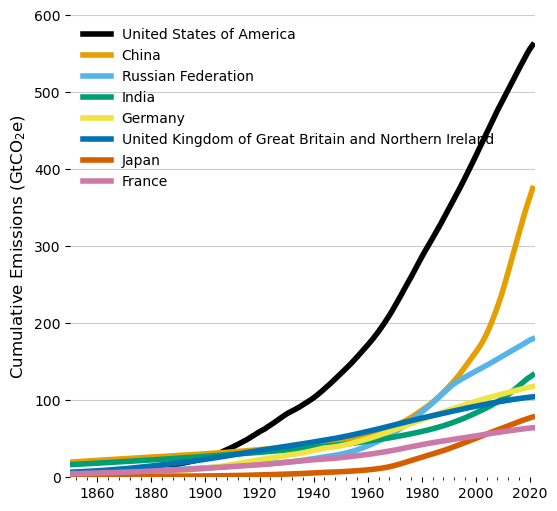

In [21]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# top 8 emitters
top_emitters = list(df_sorted.head(8).actor_id)

# wong color palette (https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40)
colors = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

for actor_id, color in zip(top_emitters, cycle(colors)):
    actor_name = df_country.loc[df_country['actor_id'] == actor_id, 'name'].values[0]
    filt = df_out['actor_id'] == actor_id
    df_tmp = df_out.loc[filt]

    ax.plot(np.array(df_tmp['year']), np.array(df_tmp['cumulative_emissions']) / 10**9, 
            linewidth=4, 
            label = actor_name,
            color=color)

    ylim = [0, 600]
    ax.set_ylim(ylim)
    ax.set_xlim([1850, 2022])

    # Turn off the display of all ticks.
    ax.tick_params(which='both',     # Options for both major and minor ticks
                   top='off',        # turn off top ticks
                   left='off',       # turn off left ticks
                   right='off',      # turn off right ticks
                   bottom='off')     # turn off bottom ticks

    # Remove x tick marks
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # major/minor tick lines
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(axis='y', 
            which='major', 
            color=[0.8, 0.8, 0.8], linestyle='-')

    ax.set_ylabel("Cumulative Emissions (GtCO$_2$e)", fontsize=12)
    ax.legend(loc='upper left', frameon=False)